<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/yolo/Train_and_Debug_YOLOv5_Models_with_Weights_%26_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://user-images.githubusercontent.com/26833433/82952157-51b7db00-9f5d-11ea-8f4b-dda1ffecf992.jpg">

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />


# Train and Debug YOLOv5 Models with Weights & Biases

In this colab,
we'll demonstrate how to use the W&B integration with
the "You Only Look Once"
(aka [YOLO](https://github.com/ultralytics/yolov5))
real-time object detection framework
to track model metrics,
inspect model outputs,
and restart interrupted runs.

### Follow along with a [video tutorial →](https://wandb.me/yolo-video)

# Setup

We begin by downloading the
[YOLOv5 GitHub repo](https://github.com/ultralytics/yolov5)
and a
[dataset of chessboard images with labeled bounding boxes around the pieces](https://public.roboflow.com/object-detection/chess-full).

We also install all the requirements for YOLOv5 and `wandb`.

In [ ]:
%%capture
!git clone https://github.com/ultralytics/yolov5.git
!curl -L "https://public.roboflow.com/ds/1BpjFZe9ST?key=KXD7eDvwTa" > roboflow.zip; unzip -o roboflow.zip; rm roboflow.zip
%cd yolov5
!pip install -r requirements.txt
!pip install wandb

# Train


YOLO comes with wandb already integrated,
so all you need to do is configure the logging
with command line arguments.

* `--project` sets the wandb project to which we're logging
(akin to a GitHub repo).
* `--upload_dataset` tells wandb
to upload the dataset as [a dataset-visualization Table](https://docs.wandb.ai/guides/datasets-and-predictions).
At regular intervals set by `--bbox_interval`,
the model's outputs on the validation set will also be logged to W&B.
* `--save_period` sets the number of epochs to wait
in between logging the model checkpoints.
If not set, only the final trained model is logged.

Even without these arguments,
basic model metrics and some model outputs will still be saved to W&B.


> _Note_: to use this same training and logging setup on a different dataset,
just [create a `data.yaml` for that dataset](https://github.com/ultralytics/yolov5/issues/12)
and provide it to the `--data` argument.

In [ ]:
!python train.py \
  --data ../data.yaml \
  --epochs 10 \
  --project yolo-wandb-demo \
  --upload_dataset \
  --bbox_interval 1 \
  --save_period 1

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-26-g14d2d2d torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=1, bucket='', cache_images=False, cfg='', data='../data.yaml', device='', entity=None, epochs=10, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='yolo-wandb-demo', quad=False, rect=False, resume=False, save_dir='yolo-wandb-demo/exp', save_period=1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=True, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir yolo-wandb-demo', view at http://localhost:6006/
2021-04-23 00:57:57.227283: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully open

Here's where you can find the uploaded evaluation results in the W&B UI:


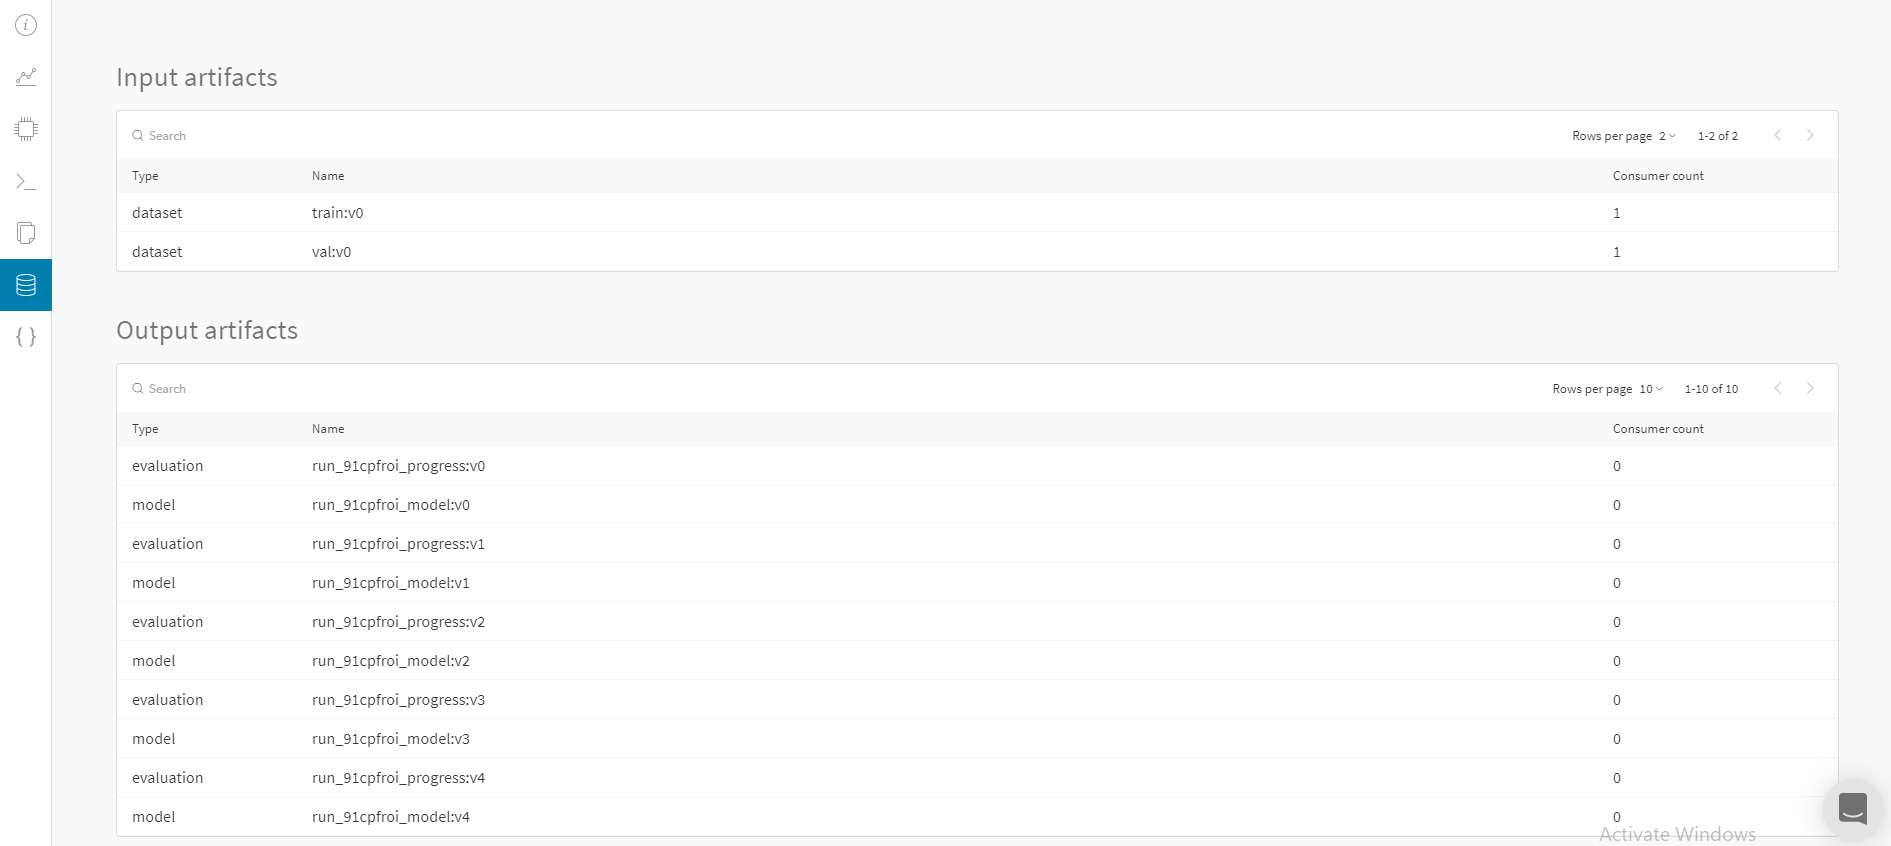

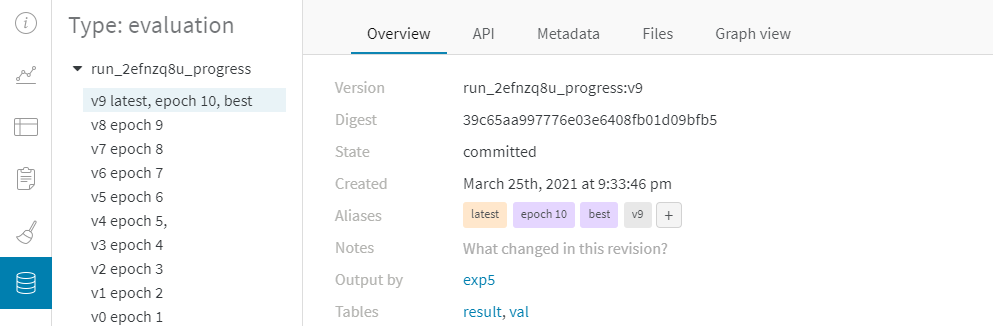


# Resume Crashed Runs

In addition to making it easier to debug our models,
the W&B integration can help rescue crash or interrupted runs.

Two steps above helped set us up for this:
1. By setting a `--save_period`, we regularly logged the model to W&B,
which means we can recreate our model and then resume the run on any
device with the dataset available.
2. By using `--upload_dataset`, we logged the data to W&B,
which means we can recreate the data as well and so
resume runs on any device, whether the dataset is present on disk or not

To resume a crashed or interrupted run:
* Go to that run's overview section on W&B dashboard
* Copy the run path
* Pass the run path as the `--resume` argument, plus the prefix
`wandb-artifact://`.
This prefix tells YOLO that the files are located on wandb, rather than locally.

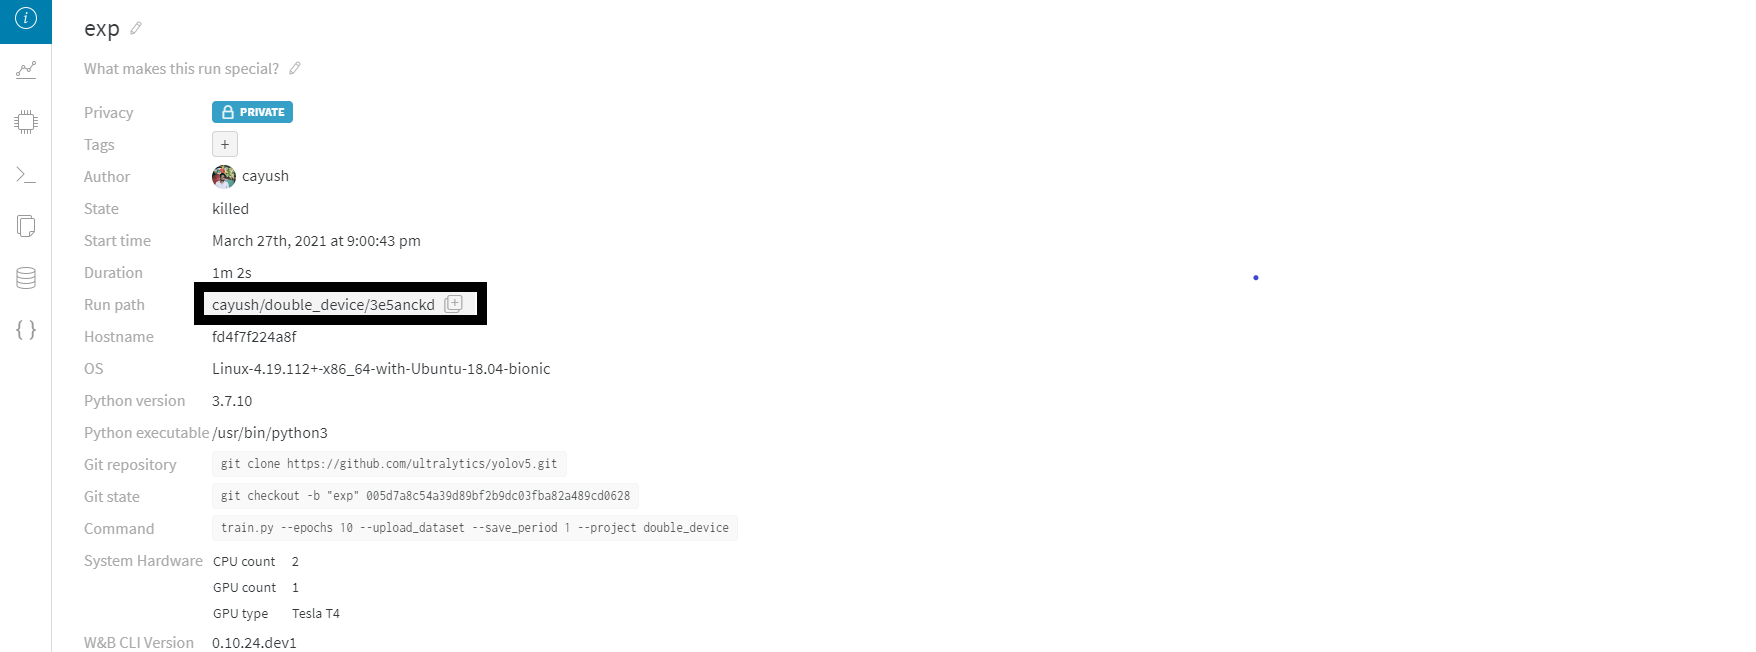


In [ ]:
crashed_run_path = "entity/project/run-id"  # your path here
!python train.py --resume wandb-artifact://{crashed_run_path}

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-14-g238583b torch 1.8.1+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='', data='data/coco128.yaml', device='', entity=None, epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume='wandb-artifact://ivangoncharov/yolo-wandb-demo/3gj9mdpe', save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, weights='yolov5s.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2021-04-19 02:21:53.019215: I tensorflow/stream_ex

# End Notes

### Distributed Data-Parallel Training

All YOLO+W&B features are
DDP-aware and compatible.
Train on as many GPUs as you can muster,
and we'll keep logging!

### Logging Large Datasets

For very large datasets,
the initial dataset upload triggered by `--log_dataset`
might be prohibitively expensive.

In that case,
check out the
[`log_dataset.py` script](https://github.com/ultralytics/yolov5/blob/master/utils/wandb_logging/log_dataset.py)
included in YOLOv5.

### `stripped` Models

At the end of training,
a "stripped" version of the model is saved
to W&B.
This version of the model file is much smaller,
but is missing
accumulated data required for resuming training.
It's intended for use in downstream inference.